*Read section 6.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Best subsets selection

In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time

In [6]:
trainf = pd.read_csv('./Datasets/house_feature_train.csv')
trainp = pd.read_csv('./Datasets/house_price_train.csv')
testf = pd.read_csv('./Datasets/house_feature_test.csv')
testp = pd.read_csv('./Datasets/house_price_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,house_id,house_age,distance_MRT,number_convenience_stores,latitude,longitude,house_price
0,210,5.2,390.5684,5,24.97937,121.54245,2724.84
1,190,35.3,616.5735,8,24.97945,121.53642,1789.29
2,328,15.9,1497.7130,3,24.97003,121.51696,556.96
3,5,7.1,2175.0300,3,24.96305,121.51254,1030.41
4,412,8.1,104.8101,5,24.96674,121.54067,2756.25


Develop a model to predict house price using the rest of the columns as predictors (except `house_id`).

In [7]:
#Model with log house price as the response and the remaining variables as predictors
model = sm.ols('np.log(house_price)~house_age+distance_MRT+number_convenience_stores+latitude+\
longitude', data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.772
Model:                             OLS   Adj. R-squared:                  0.767
Method:                  Least Squares   F-statistic:                     181.8
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           4.47e-84
Time:                         18:31:07   Log-Likelihood:                -118.47
No. Observations:                  275   AIC:                             248.9
Df Residuals:                      269   BIC:                             270.6
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -482.9401    312.000     -1.548      0.123   -1097.212     131.332
house_age                    -0.0131      0.002     -6.437      0.000      -0.017      -0.009
distance_MRT                 -0.0003   3.69e-05     -8.318      0.000      -0.000      -0.000
number_convenience_stores     0.0598      0.010      6.247      0.000       0.041       0.079
latitude                     18.7044      2.353      7.951      0.000      14.073      23.336
longitude                     0.1923      2.465      0.078      0.938      -4.660       5.045
==============================================================================
Omnibus:                        4.413   Durbin-Watson:                   2.260
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                5.515
Skew:                           0.077   Prob(JB):                       0.0634
Kurtosis:                       3.677   Cond. No.                     2.28e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Find the best subset of predictors that can predict house price in a linear regression model.**

In [11]:
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['house_age','number_convenience_stores','latitude', 'longitude','distance_MRT']]

### Best subset selection algorithm

Now, we will implement the algorithm of finding the best subset of predictors from amongst all sets of predictors.

In [12]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('np.log(house_price)~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [13]:
#Function to select the best model amongst all models with 'k' predictors
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [14]:
#Function to select the best model amongst the best models for 'k' predictors, where k = 1,2,3,..
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 5 models on 1 predictors in 0.02393651008605957 seconds.
Processed 10 models on 2 predictors in 0.04688239097595215 seconds.
Processed 10 models on 3 predictors in 0.04986691474914551 seconds.
Processed 5 models on 4 predictors in 0.029920578002929688 seconds.
Processed 1 models on 5 predictors in 0.008975982666015625 seconds.
Total elapsed time: 0.17253828048706055 seconds.


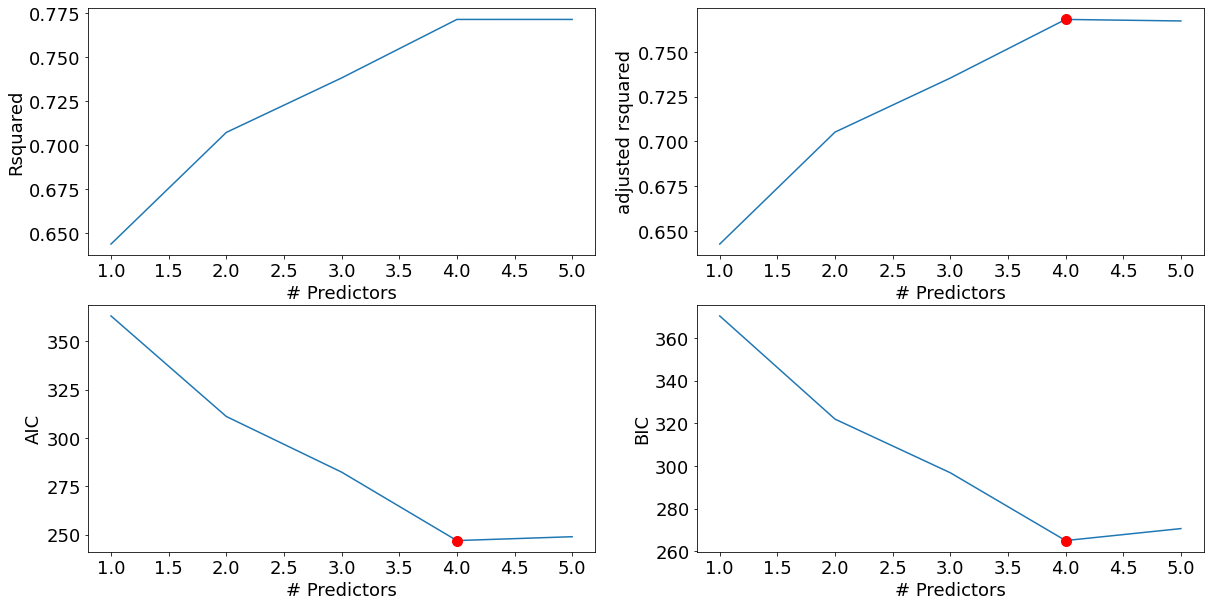

In [22]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

The model with 4 predictors is the best model, according to all 3 criteria - Adjusted R-squared, AIC and BIC.

Note that we have not considered the null model (i.e., the model with only the intercept and no predictors) explicitly in the best subsets algorithm. However, the null model is considered when selecting the best model. The R-squared and the adjusted R-squared for the null model is 0. So, if the adjusted R-squared of all the models with at least one predictor is negative, then the null model will be the best model.

In [23]:
best_subset_model = models_best.loc[4,'model']
models_best.loc[4,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.772
Model:                             OLS   Adj. R-squared:                  0.768
Method:                  Least Squares   F-statistic:                     228.0
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           2.79e-85
Time:                         19:51:50   Log-Likelihood:                -118.47
No. Observations:                  275   AIC:                             246.9
Df Residuals:                      270   BIC:                             265.0
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -459.0262     58.231     -7.883      0.000    -573.671    -344.381
house_age                    -0.0131      0.002     -6.451      0.000      -0.017      -0.009
number_convenience_stores     0.0597      0.010      6.271      0.000       0.041       0.078
latitude                     18.6828      2.332      8.012      0.000      14.092      23.274
distance_MRT                 -0.0003   2.53e-05    -12.221      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        4.422   Durbin-Watson:                   2.261
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                5.555
Skew:                           0.073   Prob(JB):                       0.0622
Kurtosis:                       3.681   Cond. No.                     4.25e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.25e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
#Finding the RMSE of the model selected using the best subset selection procedure
pred_price = np.exp(best_subset_model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

403.4635674362065

In [25]:
#RMSE of the model using all the predictors
model = sm.ols('np.log(house_price)~' + '+'.join(X.columns),data = train).fit()
pred_price = np.exp(model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

403.8409399214197

The RMSE of the best subset model is similar to the RMSE of the model with all the predictors. This is because longitude varies only in \[121.47, 121.57\]. The coefficient of longitude is 0.1923 in the model with all the predictors. So, the change in the response due to longitude is in \[23.36, 23.38 \]. This change in the response due to longitude is almost a constant, and hence is adjusted in the intercept of the model without longitude. Note the intercept of the model without longitude is 23.91 more than the intercept of the model with longitude.

In [26]:
[0.1923*train.longitude.min(),0.1923*train.longitude.max()]

[23.359359818999998, 23.377193721]

### Including interactions for best subset selection
**Let's perform best subset selection including all the predictors and their 2-factor interactions**

In [36]:
#Creating a dataframe with all the predictors
X = train[['house_age', 'distance_MRT', 'number_convenience_stores','latitude','longitude']]
#Since 'X' will change when we include interactions, we need a backup containing all individual predictors
X_backup = train[['house_age', 'distance_MRT', 'number_convenience_stores','latitude','longitude']]

In [38]:
#Including 2-factor interactions of predictors in train and 'X'. Note that we need train to develop the model, and X to 
#find 'k' variable subsets from amongst all the predictors under consideration
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

In [41]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 15 models on 1 predictors in 0.07200050354003906 seconds.
Processed 105 models on 2 predictors in 0.536522388458252 seconds.
Processed 455 models on 3 predictors in 2.6639997959136963 seconds.
Processed 1365 models on 4 predictors in 9.176022052764893 seconds.
Processed 3003 models on 5 predictors in 24.184194803237915 seconds.
Processed 5005 models on 6 predictors in 43.54697918891907 seconds.
Processed 6435 models on 7 predictors in 65.83688187599182 seconds.
Processed 6435 models on 8 predictors in 78.97277760505676 seconds.
Processed 5005 models on 9 predictors in 64.53991365432739 seconds.
Processed 3003 models on 10 predictors in 38.39328980445862 seconds.
Processed 1365 models on 11 predictors in 18.715795755386353 seconds.
Processed 455 models on 12 predictors in 6.93279504776001 seconds.
Processed 105 models on 13 predictors in 1.6240253448486328 seconds.
Processed 15 models on 14 predictors in 0.256000280380249 seconds.
Processed 1 models on 15 predictors in 0.02400

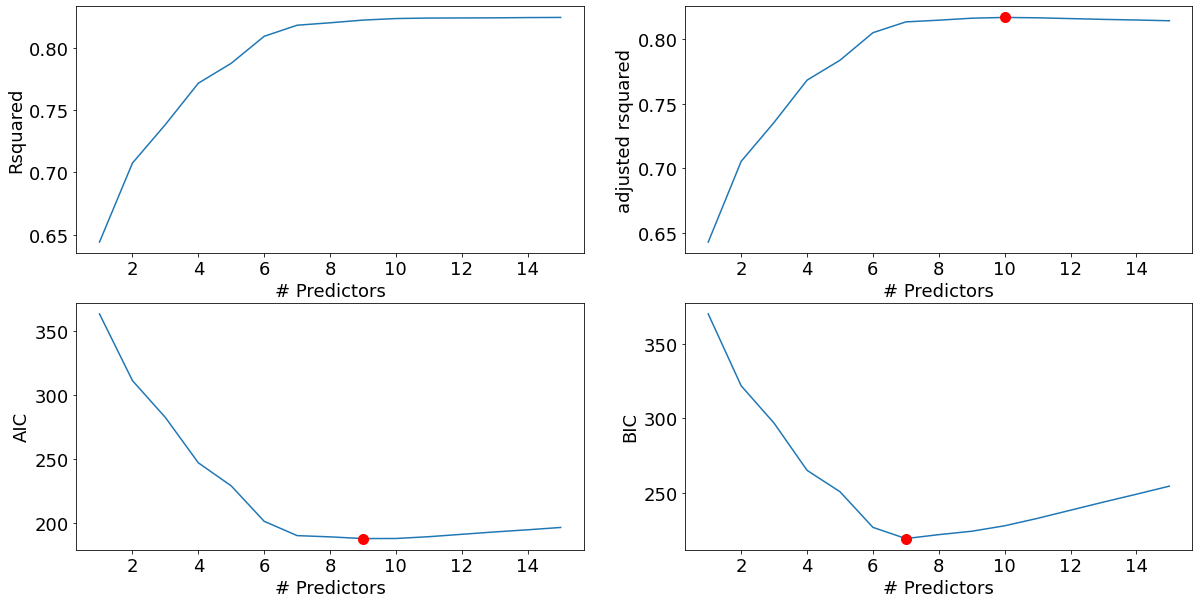

In [42]:
best_sub_plots()

The model with 7 predictors is the best model based on the BIC criterion, and very close to the best model based on the AIC and Adjusted R-squared criteria. Let us select the model with 7 predictors.

In [53]:
best_interaction_model = models_best['model'][7]
best_interaction_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.818
Model:                             OLS   Adj. R-squared:                  0.814
Method:                  Least Squares   F-statistic:                     171.7
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           5.29e-95
Time:                         20:17:02   Log-Likelihood:                -87.046
No. Observations:                  275   AIC:                             190.1
Df Residuals:                      267   BIC:                             219.0
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -1316.6156    135.152     -9.742      0.000   -1582.716   -1050.515
distance_MRT                               0.2424      0.044      5.539      0.000       0.156       0.329
number_convenience_stores                152.0179     23.356      6.509      0.000     106.033     198.003
latitude                                  53.0284      5.413      9.797      0.000      42.371      63.686
house_age_longitude                       -0.0001   1.51e-05     -6.842      0.000      -0.000   -7.36e-05
distance_MRT_number_convenience_stores -5.691e-05   1.19e-05     -4.763      0.000   -8.04e-05   -3.34e-05
distance_MRT_latitude                     -0.0097      0.002     -5.544      0.000      -0.013      -0.006
number_convenience_stores_latitude        -6.0847      0.935     -6.506      0.000      -7.926      -4.243
==============================================================================
Omnibus:                        5.350   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                7.524
Skew:                           0.045   Prob(JB):                       0.0232
Kurtosis:                       3.805   Cond. No.                     2.78e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that only 3 of the 10 two factor interactions are included in the best subset model, and the predictor `longitude` has been dropped.

In [54]:
#Finding the RMSE of the model selected using the best subset selection procedure, where the predictors
#include 2-factor interactions
pred_price = np.exp(best_interaction_model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

346.4100962681362

In [45]:
#Model with the predictors and all their 2-factor interactions
model = sm.ols('np.log(house_price)~' + '+'.join(X.columns),data = train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.825
Model:                             OLS   Adj. R-squared:                  0.814
Method:                  Least Squares   F-statistic:                     81.14
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           1.33e-88
Time:                         20:13:01   Log-Likelihood:                -82.228
No. Observations:                  275   AIC:                             196.5
Df Residuals:                      259   BIC:                             254.3
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                               7.455e+05   1.03e+06      0.725      0.469   -1.28e+06    2.77e+06
house_age                                 83.1021     40.562      2.049      0.041       3.228     162.976
distance_MRT                               0.1391      0.174      0.798      0.425      -0.204       0.482
number_convenience_stores                252.5261    212.276      1.190      0.235    -165.481     670.533
latitude                               -2.992e+04   4.12e+04     -0.727      0.468   -1.11e+05    5.12e+04
longitude                              -6144.1732   8454.331     -0.727      0.468   -2.28e+04    1.05e+04
house_age_distance_MRT                 -2.904e-06   4.44e-06     -0.654      0.514   -1.16e-05    5.84e-06
house_age_number_convenience_stores        0.0011      0.001      1.409      0.160      -0.000       0.003
house_age_latitude                         0.2119      0.261      0.811      0.418      -0.303       0.726
house_age_longitude                       -0.7274      0.330     -2.207      0.028      -1.376      -0.078
distance_MRT_number_convenience_stores -6.192e-05   1.99e-05     -3.115      0.002      -0.000   -2.28e-05
distance_MRT_latitude                     -0.0082      0.003     -2.387      0.018      -0.015      -0.001
distance_MRT_longitude                     0.0005      0.001      0.417      0.677      -0.002       0.003
number_convenience_stores_latitude        -6.4014      1.113     -5.753      0.000      -8.592      -4.210
number_convenience_stores_longitude       -0.7620      1.700     -0.448      0.654      -4.109       2.585
latitude_longitude                       246.5995    338.773      0.728      0.467    -420.500     913.699
==============================================================================
Omnibus:                        3.911   Durbin-Watson:                   2.134
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                4.552
Skew:                           0.090   Prob(JB):                        0.103
Kurtosis:                       3.604   Cond. No.                     1.05e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [46]:
# RMSE of the model using all the predictors and their 2-factor interactions
pred_price = np.exp(model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

360.40099598821615

The best subset model seems to be slightly better than the model with all the predictors, based on the RMSE on test data.

## Stepwise selection
Best subset selection cannot be used in case of even a slightly large number of predictors. In the previous example, we had 15 predictors. The number of models that we developed to find the best subset of predictors from the set of 15 predictors was $2^{15} \approx 32,000$. In case of 20 predictors, the number of models to use the best subset selection approach will be $2^{20} \approx 1$ million, which is computationally too expensive. Due to this limitation of the best subsets selection method, we will use stepwise regression, which explores a far more restricted set of models, and thus is an attractive alternative to the best subset selection method.

## Forward stepwise selection
Source - Page 229: "Forward stepwise selection is a computationally efficient alternative to best subset selection. While the best subset selection procedure considers all $2^p$ possible models containing subsets of the $p$ predictors, forward stepwise considers a much smaller set of models. Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model. In particular, at each step the variable that gives the greatest additional improvement to the fit is added to the model."

In [56]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [57]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [64]:
models_best = forward_selection()

Processed  15 models on 1 predictors in 0.06280803680419922 seconds.
Processed  14 models on 2 predictors in 0.054885149002075195 seconds.
Processed  13 models on 3 predictors in 0.05983686447143555 seconds.
Processed  12 models on 4 predictors in 0.06781768798828125 seconds.
Processed  11 models on 5 predictors in 0.07380270957946777 seconds.
Processed  10 models on 6 predictors in 0.07380390167236328 seconds.
Processed  9 models on 7 predictors in 0.06981182098388672 seconds.
Processed  8 models on 8 predictors in 0.07480072975158691 seconds.
Processed  7 models on 9 predictors in 0.0718071460723877 seconds.
Processed  6 models on 10 predictors in 0.06380081176757812 seconds.
Processed  5 models on 11 predictors in 0.054854631423950195 seconds.
Processed  4 models on 12 predictors in 0.05385565757751465 seconds.
Processed  3 models on 13 predictors in 0.04188799858093262 seconds.
Processed  2 models on 14 predictors in 0.027925491333007812 seconds.
Processed  1 models on 15 predictor

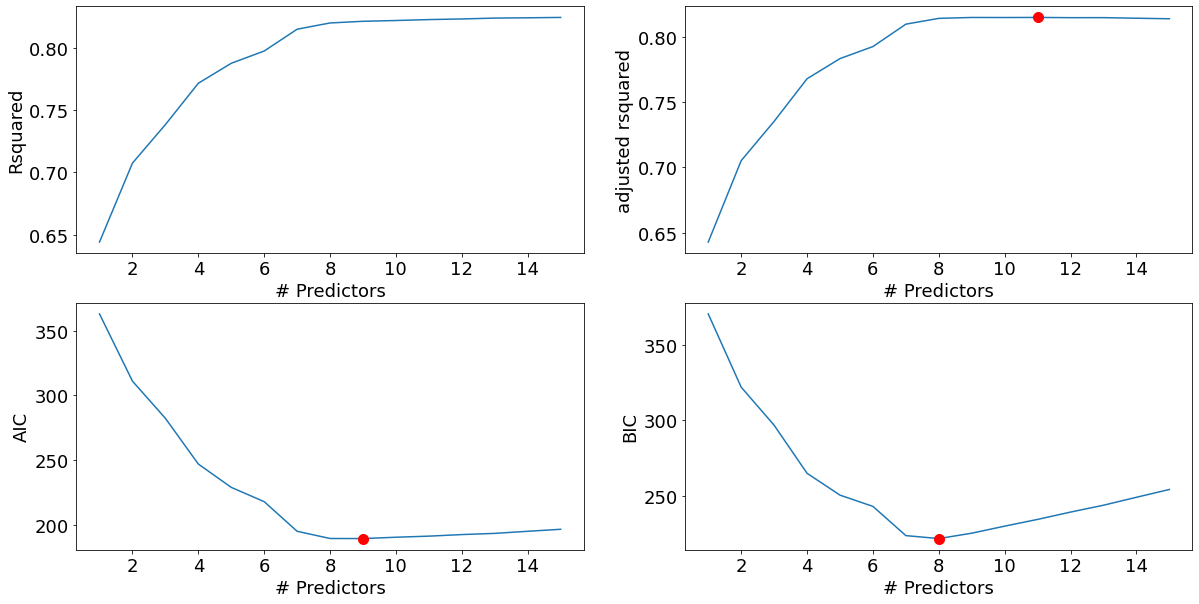

In [65]:
best_sub_plots()

The model with 8 predictors is the best model based on the BIC criterion, and very close to the best model based on the AIC and Adjusted R-squared criteria. Let us select the model with 8 predictors.

In [76]:
best_fwd_reg_model = models_best['model'][8]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.820
Model:                             OLS   Adj. R-squared:                  0.815
Method:                  Least Squares   F-statistic:                     151.6
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           1.91e-94
Time:                         20:35:14   Log-Likelihood:                -85.667
No. Observations:                  275   AIC:                             189.3
Df Residuals:                      266   BIC:                             221.9
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -1365.5045    154.113     -8.860      0.000   -1668.942   -1062.067
distance_MRT_longitude                     0.0021      0.000      5.062      0.000       0.001       0.003
latitude                                  54.9844      6.171      8.909      0.000      42.833      67.136
house_age_longitude                       -0.3240      0.119     -2.725      0.007      -0.558      -0.090
number_convenience_stores_longitude        1.3242      0.212      6.246      0.000       0.907       1.742
distance_MRT_number_convenience_stores -4.805e-05   1.21e-05     -3.973      0.000   -7.19e-05   -2.42e-05
number_convenience_stores_latitude        -6.4419      1.032     -6.243      0.000      -8.473      -4.410
distance_MRT_latitude                     -0.0101      0.002     -5.067      0.000      -0.014      -0.006
house_age                                 39.3625     14.450      2.724      0.007      10.911      67.814
==============================================================================
Omnibus:                        5.017   Durbin-Watson:                   2.176
Prob(Omnibus):                  0.081   Jarque-Bera (JB):                6.923
Skew:                           0.022   Prob(JB):                       0.0314
Kurtosis:                       3.776   Cond. No.                     1.56e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_price = np.exp(best_fwd_reg_model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

364.2004089481364

We get a different model than what we got with the best subsets selection method. However, we got it in 0.9 seconds, instead of 6 minutes taken by the best subset selection algorithm. Note that this model has a higher RMSE as compared to the model obtained with the best subset selection procedure, which is expected. However, the RMSE is even slightly higher than the model that includes all the two factor interactions. This may be due to the following reasons:

- This may be due to chance - the test data set may be biased.

- The stepwise variable selection algorithms are greedy algorithms, and certainly don't guarantee the best model, or even a model better than the one without variable selection. However, in general, they are likely to provide a better model than the base model that includes all the predictors, especially if there are several predictors that are not associated with the response.

- For metrics such as adjusted R-squared, the adjustment is not directly tied to the model being more accurate on test data. The adjustment only ensures that the adjusted R-squared increases if the added predictor sufficiently reduces the RSS (Residual sum of squares) on training data.

- AIC is an unbiased estimate of test error. However, AIC will have some variance as we are using sample data for training the model.

## Backward Stepwise Selection
Source - Page 231: "Like forward stepwise selection, backward stepwise selection provides an efficient alternative to best subset selection. However, unlike forward stepwise selection, it begins with the full least squares model containing all $p$ predictors, and then iteratively removes the least useful predictor, one-at-a-time."

Let us try the backward selection procedure on the model with 15 predictors - *house_age, distance_MRT, number_convenience_stores, latitude, longitude* and their 2-factor interactions.

In [83]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [84]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [85]:
models_best = backward_selection()

Processed  15 models on 14 predictors in 0.24733757972717285 seconds.
Processed  14 models on 13 predictors in 0.1765275001525879 seconds.
Processed  13 models on 12 predictors in 0.16356277465820312 seconds.
Processed  12 models on 11 predictors in 0.13364267349243164 seconds.
Processed  11 models on 10 predictors in 0.11968183517456055 seconds.
Processed  10 models on 9 predictors in 0.09571337699890137 seconds.
Processed  9 models on 8 predictors in 0.08377647399902344 seconds.
Processed  8 models on 7 predictors in 0.06981253623962402 seconds.
Processed  7 models on 6 predictors in 0.048902273178100586 seconds.
Processed  6 models on 5 predictors in 0.04088902473449707 seconds.
Processed  5 models on 4 predictors in 0.029920101165771484 seconds.
Processed  4 models on 3 predictors in 0.020944595336914062 seconds.
Processed  3 models on 2 predictors in 0.013962507247924805 seconds.
Processed  2 models on 1 predictors in 0.007978677749633789 seconds.
Total elapsed time: 1.28652977943

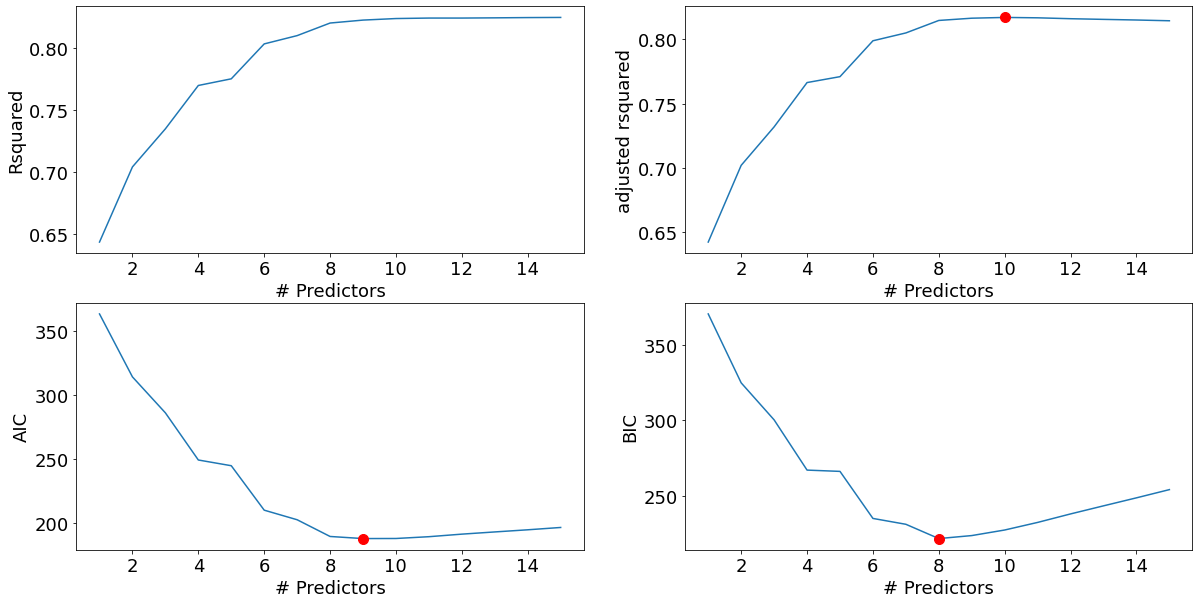

In [86]:
best_sub_plots()

In [87]:
best_bwd_reg_model = models_best['model'][8]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     np.log(house_price)   R-squared:                       0.820
Model:                             OLS   Adj. R-squared:                  0.815
Method:                  Least Squares   F-statistic:                     151.5
Date:                 Thu, 16 Feb 2023   Prob (F-statistic):           2.00e-94
Time:                         20:40:43   Log-Likelihood:                -85.714
No. Observations:                  275   AIC:                             189.4
Df Residuals:                      266   BIC:                             222.0
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                              -1317.5329    145.605     -9.049      0.000   -1604.218   -1030.847
house_age                                 57.3124     14.583      3.930      0.000      28.600      86.025
distance_MRT                               0.2365      0.047      5.044      0.000       0.144       0.329
number_convenience_stores                154.8362     24.984      6.197      0.000     105.644     204.029
house_age_longitude                       -0.4717      0.120     -3.931      0.000      -0.708      -0.235
distance_MRT_number_convenience_stores -4.789e-05   1.24e-05     -3.869      0.000   -7.23e-05   -2.35e-05
distance_MRT_latitude                     -0.0095      0.002     -5.050      0.000      -0.013      -0.006
number_convenience_stores_latitude        -6.1977      1.001     -6.194      0.000      -8.168      -4.228
latitude_longitude                         0.4366      0.048      9.100      0.000       0.342       0.531
==============================================================================
Omnibus:                        4.945   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                6.228
Skew:                           0.110   Prob(JB):                       0.0444
Kurtosis:                       3.703   Cond. No.                     3.01e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.01e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We get a slightly different model than what we got with the best subsets selection method and the forward selection method. As in forward selection, we got it relatively very quickly (in 1.28 seconds), instead of 6 minutes taken by the best subset selection algorithm.

In [88]:
#Finding the RMSE of the model selected using the backward selection procedure, where the predictors
#include 2-factor interactions
pred_price = np.exp(best_bwd_reg_model.predict(test))
np.sqrt(((pred_price - test.house_price)**2).mean())

363.63365786020694

Note that we have not considered the null model (i.e., the model with only the intercept and no predictors) explicitly in the forward and backward stepwise algorithms. However, the null model is considered when selecting the best model. The R-squared and the adjusted R-squared for the null model is 0. So, if the adjusted R-squared of all the models with at least one predictor is negative, then the null model will be the best model.